In [21]:
try:
    from datetime import datetime
    import numpy as np
    import pandas
    from pandas.plotting import scatter_matrix
    import matplotlib.pyplot as plt
    from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

    datetimeNowBegin = datetime.now()
    sys.stdout.write("Début du script: " + str(datetimeNowBegin))
except:
    %run Install.ipynb

Début du script: 2019-04-27 17:58:39.689982

In [40]:
file_name = "res/rankingWorldCupEUWeek1-2"
MAX_GAME = 10

In [57]:
data = pandas.read_csv(file_name + '.csv', sep=";", header=0, index_col=0)

data["Games played"] = pandas.Series(MAX_GAME - data[data.columns[2:12]].isna().sum(axis=1), index=data.index)
data["Kills"] = pandas.Series(data[data.columns[2:12]].sum(axis=1), index=data.index)
data["Average kill"] = round(pandas.Series(data[data.columns[2:12]].sum(axis=1), index=data.index) / data["Games played"], 2)
data["Average pos"] = round(pandas.Series(data[data.columns[12:22]].sum(axis=1), index=data.index) / data["Games played"], 2)
data["Kill ratio"] = round(pandas.Series(data["Kills"] / data["Points"] * 100), 0)
data["Pos ratio"] = round(pandas.Series(100 - data["Kills"] / data["Points"] * 100), 0)
countZero = lambda row: sum(row["Kill(s) Game "+str(game)] == 0 and row["Position Game "+str(game)] > 25 for game in range(1, 11))
data["0 pt game(s)"] = data.apply(countZero, axis=1)
countTop1 = lambda row: sum(row[column] == 1 for column in data.columns[12:22])
data["Top 1"] = data.apply(countTop1, axis=1)
countSpawnDeath = lambda row: sum(row[column] < 300 for column in data.columns[22:32])
data["Lobby return"] = data.apply(countSpawnDeath, axis=1)

,Time Game 1,Time Game 2,Time Game 3,Time Game 4,Time Game 5,Time Game 6,Time Game 7,Time Game 8,Time Game 9,Time Game 10,0 pt game(s),Games played,Lobby return
Player,,,,,,,,,,,,,
E11 Stompy,1382.0,1593.0,1541.0,225.0,499.0,1596.0,1459.0,1585.0,1710.0,NaN,1,9,1
TQ Prisi0n3r0,1548.0,628.0,1539.0,1645.0,1619.0,510.0,372.0,1725.0,1723.0,NaN,2,9,0
NRG benjуfishу,1421.0,465.0,1641.0,1342.0,412.0,452.0,1557.0,1658.0,1739.0,1444.0,2,10,0
hREDS BELAEU,1371.0,1490.0,1624.0,1459.0,1484.0,497.0,1538.0,638.0,587.0,1585.0,2,10,0
Gambit.letw1k3,1398.0,1778.0,1011.0,612.0,1491.0,196.0,238.0,855.0,1732.0,1604.0,3,10,2
LDLC Nayte,1498.0,478.0,1450.0,1527.0,1755.0,1424.0,1684.0,485.0,988.0,NaN,2,9,0
S2V DiegoGB,1219.0,1420.0,306.0,1570.0,1529.0,1678.0,1583.0,544.0,414.0,1647.0,2,10,0
ÐRG,633.0,1416.0,197.0,1557.0,1401.0,1810.0,330.0,760.0,1930.0,1850.0,4,10,1
VGIA Khisanth,1450.0,1522.0,1300.0,1527.0,505.0,1571.0,321.0,1502.0,945.0,1610.0,2,10,0


In [58]:
#Basic stats
print("Shape :\n", data.shape)
print("Basic stats :\n", data.describe())
print(data.columns)
data = data.fillna(0)


Shape :
 (3000, 61)
Basic stats :
               Rank       Points  Kill(s) Game 1  Kill(s) Game 2  \
count  3000.000000  3000.000000     3000.000000     2999.000000   
mean   1500.500000    21.140667        0.936667        0.974325   
std     866.169729    10.574158        1.392349        1.425610   
min       1.000000     2.000000        0.000000        0.000000   
25%     750.750000    13.000000        0.000000        0.000000   
50%    1500.500000    20.000000        0.000000        0.000000   
75%    2250.250000    28.000000        1.000000        1.000000   
max    3000.000000    74.000000       11.000000       11.000000   

       Kill(s) Game 3  Kill(s) Game 4  Kill(s) Game 5  Kill(s) Game 6  \
count     2998.000000     2997.000000     2993.000000     2990.000000   
mean         0.939293        0.942609        0.982960        0.936455   
std          1.363638        1.438333        1.509122        1.397547   
min          0.000000        0.000000        0.000000        0.000000

In [39]:
selected_columns = ['Rank', 'Points', 'Kills', 'Average kill', 'Average pos', 'Kill ratio', 'Pos ratio', '0 pt game(s)', 'Top 1', 'Games played']
data[selected_columns].iloc[-100:]

,Rank,Points,Kills,Average kill,Average pos,Kill ratio,Pos ratio,0 pt game(s),Top 1,Games played
Player,,,,,,,,,,
Tv_QuiiK_YT,2901,38,10.0,1.00,40.00,26.0,74.0,3,0,10
InevitableFPS,2902,38,13.0,1.30,55.20,34.0,66.0,4,0,10
Majiin_Killua,2903,38,13.0,1.44,26.89,34.0,66.0,3,1,9
idan giron,2904,38,13.0,1.44,29.11,34.0,66.0,3,1,9
vk.com azemar,2905,38,14.0,1.40,31.90,37.0,63.0,3,1,10
Pure Logan,2906,38,14.0,1.40,33.00,37.0,63.0,4,1,10
ttv GonzoUK,2907,38,14.0,1.40,35.30,37.0,63.0,3,1,10
OTW NJR,2908,38,14.0,1.40,44.20,37.0,63.0,3,1,10
1UP ZORD,2909,38,14.0,1.40,44.50,37.0,63.0,4,1,10


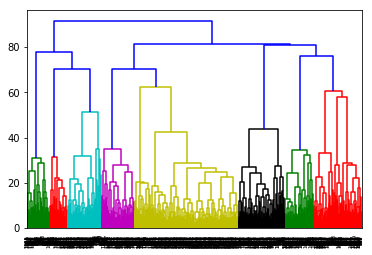

In [216]:
Z = linkage(data[data.columns[2:12]], method='ward', metric='euclidean')
dendrogram(Z)
plt.show()

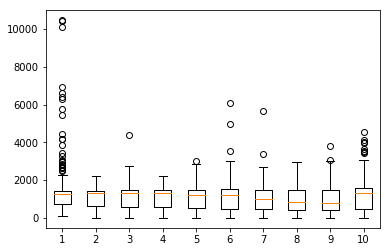

In [20]:
box_data = [data[column] for column in data[data.columns[22:32]]]
plt.boxplot(box_data)
plt.show()

In [231]:
groupes_cah = fcluster(Z,t=65,criterion='distance')

idg = np.argsort(groupes_cah)
#affichage des observations et leurs groupes
#print(pandas.DataFrame(data.index[idg], groupes_cah[idg]))


clusters = {i+1: [] for i in range(groupes_cah[idg][-1])}

for index in range(len(data.index[idg])):
    clusters[groupes_cah[idg][index]].append(data.index[idg][index])   

selected_columns = ['Rank', 'Kills', 'Average kill', 'Average pos', 'Kill ratio', 'Pos ratio', '0 pt game(s)', 'Games played']

boxdata = {}
for i in range(groupes_cah[idg][-1]):
    print("Cluster ", i+1)
    print(data.loc[data.index.isin(clusters[i+1])].describe()[selected_columns])
    for field in selected_columns:
        try:
            boxdata[field].append(data.loc[data.index.isin(clusters[i+1])][field])
        except:
            boxdata[field] = []
            boxdata[field].append(data.loc[data.index.isin(clusters[i+1])][field])


Cluster  1
              Rank       Kills  Average kill  Average pos  Kill ratio  \
count   100.000000  100.000000     100.00000   100.000000   100.00000   
mean    488.320000   25.020000       2.53740    23.888900    61.97000   
std     330.495614    6.471351       0.68401     3.704714    10.71811   
min       9.000000   13.000000       1.30000    12.250000    42.00000   
25%     179.750000   21.000000       2.10000    21.867500    54.00000   
50%     460.000000   23.000000       2.40000    23.800000    62.00000   
75%     747.000000   29.000000       2.90000    26.075000    67.25000   
max    1175.000000   43.000000       4.67000    33.500000    88.00000   

       Pos ratio  0 pt game(s)  Games played  
count  100.00000    100.000000     100.00000  
mean    38.03000      2.670000       9.89000  
std     10.71811      1.477474       0.37322  
min     12.00000      0.000000       8.00000  
25%     32.75000      2.000000      10.00000  
50%     38.00000      3.000000      10.00000  
75

Rank


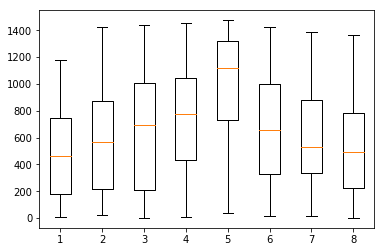

Kills


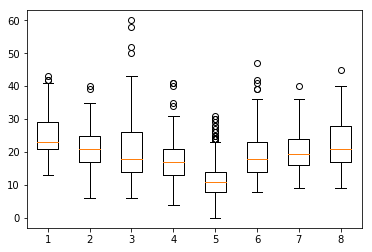

Average kill


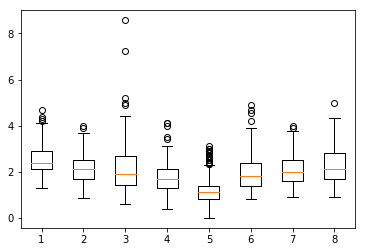

Average pos


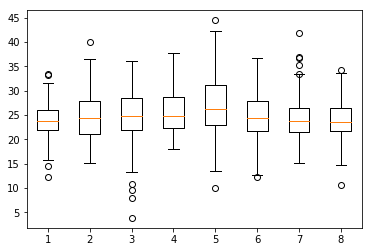

Kill ratio


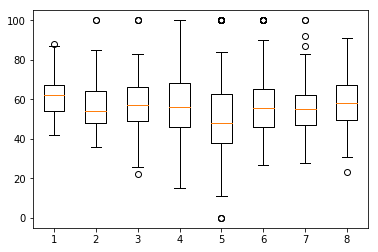

Pos ratio


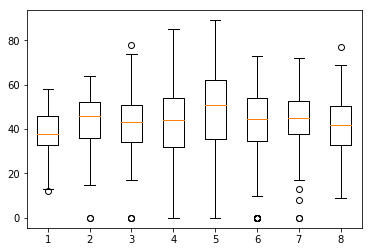

0 pt game(s)


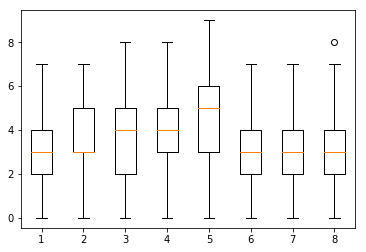

Games played


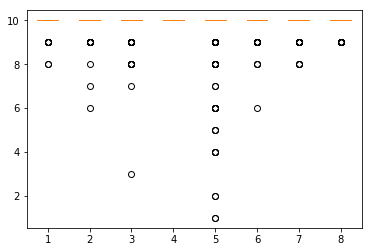

In [232]:
for field in selected_columns:
    print(field)
    plt.boxplot(boxdata[field])
    plt.show()


In [298]:
groupes_modify = np.array(groupes_cah[idg])
groupes_modify[0] = 9
groupes_modify[1] = 9
groupes_modify[2] = 9
groupes_modify[3] = 9
groupes_modify[4] = 9

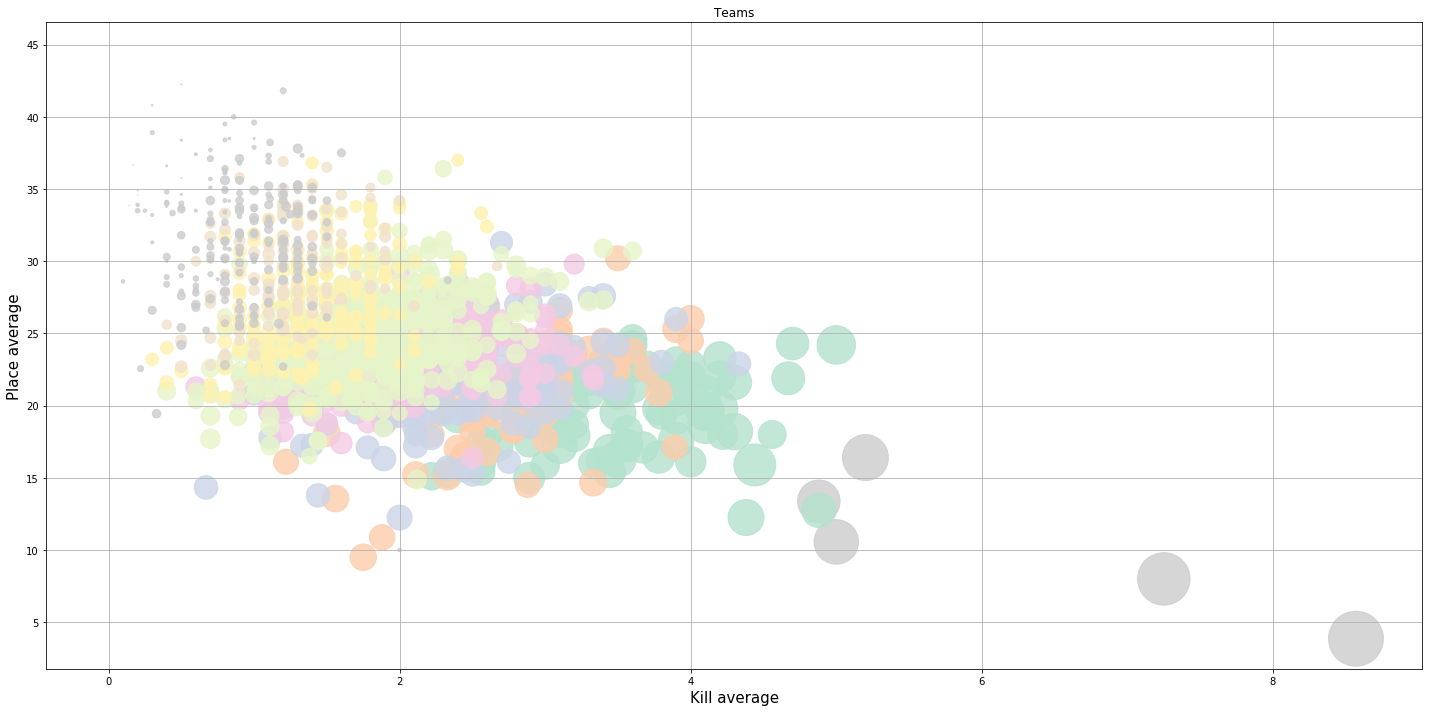

In [299]:
# Marker size in units of points^2
points = (data["Points"]/2)**2
group = groupes_modify

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(data["Average kill"], data["Average pos"], c=group, s=points, alpha=0.8, cmap=plt.cm.get_cmap("Pastel2"))

ax.set_xlabel('Kill average', fontsize=15)
ax.set_ylabel('Place average', fontsize=15)
ax.set_title('Teams')

ax.grid(True)
fig.tight_layout()
plt.show()

In [172]:
with open(file_name + '.json', 'w') as jsonfile:
    jsonfile.write(data[["Points", "Games played", "Kills", "Average kill", "Average pos", "0 pt game(s)", "Kill ratio", "Pos ratio"]].to_json(orient='index'))